In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyLDAvis
!pip install nltk


from gensim.models import LdaMulticore
import pandas as pd
import bz2
import json
import string
import re
import matplotlib.pyplot as plt
import requests
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from functools import partial



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install --upgrade pandas==1.3.4



In [3]:
#data2019 = pd.read_pickle('/content/drive/MyDrive/ADA/preprocessed_quotes_2019.pkl')
data2020 = pd.read_pickle('/content/drive/MyDrive/ADA/preprocessed_quotes_2020_topics.pkl')




In [5]:
data2020

,index,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]",0.175650,0.000000,0.00000,0.177432,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.359632,0.000000,0.000000,0.000000,0.000000,0.153952,0.0000,0.0000,0.000000
1,1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...",0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.748172,0.000000,0.139328,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
2,2,1,male,[gymnast],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.366010,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.210399,0.000000,0.253592,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
3,3,1,male,[handball player],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.365672,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.210396,0.000000,0.253931,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
4,4,3,male,[basketball player],"[Luxembourg, United States of America]",23,Very High,"[protect, whats, stand, believe, always, faith...",0.000000,0.000000,0.11884,0.148174,0.0000,0.517570,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115416,0.000000,0.000000,0.0000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657236,30438,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi...",0.000000,0.000000,0.00000,0.000000,0.0000,0.225321,0.116896,0.0000,0.160957,0.000000,0.000000,0.000000,0.000000,0.000000,0.170770,0.242723,0.000000,0.0000,0.0000,0.000000
657237,30439,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology...",0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.171003,0.370288,0.000000,0.000000,0.183011,0.000000,0.0000,0.0000,0.161413
657238,30440,1,male,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]",0.012500,0.012500,0.01250,0.262500,0.0125,0.012500,0.012500,0.2625,0.012500,0.012500,0.012500,0.012500,0.262500,0.012500,0.012500,0.012500,0.012500,0.0125,0.0125,0.012500
657239,30441,1,male,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w...",0.090682,0.194139,0.00000,0.000000,0.0000,0.000000,0.148963,0.0000,0.000000,0.000000,0.000000,0.194239,0.000000,0.124131,0.000000,0.000000,0.000000,0.0000,0.0000,0.189513


In [4]:
with open("/content/drive/MyDrive/ADA/jobs_sports.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_sports = pd.DataFrame(text,columns=['sports'])

with open("/content/drive/MyDrive/ADA/jobs_media.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_media = pd.DataFrame(text,columns=['media'])

with open("/content/drive/MyDrive/ADA/jobs_important_people.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_important = pd.DataFrame(text,columns=['important'])

with open("/content/drive/MyDrive/ADA/jobs_art.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_art = pd.DataFrame(text,columns=['art'])

with open("/content/drive/MyDrive/ADA/jobs_academics.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_academics = pd.DataFrame(text,columns=['academics'])




In [6]:
list_sports = list(df_sports.sports)
list_media = list(df_media.media)
list_important = list(df_important.important)
list_art = list(df_art.art)
list_academics = list(df_academics.academics)

In [7]:
Class_Occupation = []

for i in range(data2020.shape[0]):
  person_occ = []
  if data2020.iloc[i].occupation is not None:
    for occ in data2020.iloc[i].occupation:
      if occ in list_sports:
        person_occ.append('sports')
        #print('ENTERED 1')
      if occ in list_media:
        person_occ.append('media')
        #print('ENTERED 2')
      if occ in list_important:
        person_occ.append('economy_politics')
        #print('ENTERED 3')
      if occ in list_art:
        person_occ.append('art')
        #print('ENTERED 4')
      if occ in list_academics:
        person_occ.append('academics')
        #print('ENTERED 5')

      if len(person_occ) == 0:
        person_occ.append(9999)
  else: 
      person_occ.append(9999)
  Class_Occupation.append(person_occ)




In [8]:

data2020['Class_Occup'] = pd.Series(Class_Occupation)
data2020

,index,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Class_Occup
0,0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]",0.175650,0.000000,0.00000,0.177432,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.359632,0.000000,0.000000,0.000000,0.000000,0.153952,0.0000,0.0000,0.000000,[9999]
1,1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...",0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.748172,0.000000,0.139328,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,[sports]
2,2,1,male,[gymnast],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.366010,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.210399,0.000000,0.253592,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,[9999]
3,3,1,male,[handball player],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.365672,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.210396,0.000000,0.253931,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,[sports]
4,4,3,male,[basketball player],"[Luxembourg, United States of America]",23,Very High,"[protect, whats, stand, believe, always, faith...",0.000000,0.000000,0.11884,0.148174,0.0000,0.517570,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115416,0.000000,0.000000,0.0000,0.0000,0.000000,[sports]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657236,30438,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi...",0.000000,0.000000,0.00000,0.000000,0.0000,0.225321,0.116896,0.0000,0.160957,0.000000,0.000000,0.000000,0.000000,0.000000,0.170770,0.242723,0.000000,0.0000,0.0000,0.000000,[sports]
657237,30439,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology...",0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.171003,0.370288,0.000000,0.000000,0.183011,0.000000,0.0000,0.0000,0.161413,[sports]
657238,30440,1,male,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]",0.012500,0.012500,0.01250,0.262500,0.0125,0.012500,0.012500,0.2625,0.012500,0.012500,0.012500,0.012500,0.262500,0.012500,0.012500,0.012500,0.012500,0.0125,0.0125,0.012500,"[art, art, art]"
657239,30441,1,male,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w...",0.090682,0.194139,0.00000,0.000000,0.0000,0.000000,0.148963,0.0000,0.000000,0.000000,0.000000,0.194239,0.000000,0.124131,0.000000,0.000000,0.000000,0.0000,0.0000,0.189513,[art]


In [9]:
data2020.drop(columns = 'index', inplace = True)

In [9]:
data2020

,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,Class_Occup
0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]",[9999]
1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...",[sports]
2,1,male,[gymnast],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",[9999]
3,1,male,[handball player],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",[sports]
4,3,male,[basketball player],"[Luxembourg, United States of America]",23,Very High,"[protect, whats, stand, believe, always, faith...",[sports]
...,...,...,...,...,...,...,...,...
657236,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi...",[sports]
657237,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology...",[sports]
657238,1,male,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]","[art, art, art]"
657239,1,male,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w...",[art]


In [84]:
from scipy.stats import chi2_contingency
import numpy as np

# Find correlation using a chi squared test 
def find_correlation (df):
  df_ = df.copy()
  factors_paired = [(i,j) for i in df_.columns.values for j in df_.columns.values] 

  chi2, p_values =[], []

  for f in factors_paired:
      if f[0] != f[1]:
          chitest = chi2_contingency(pd.crosstab(df_[f[0]], df_[f[1]]))   
          chi2.append(chitest[0])
          p_values.append(chitest[1])
      else:      # for same factor pair
          chi2.append(0)
          p_values.append(0)

  chi2 = np.array(chi2).reshape((df.shape[1],df.shape[1])) 
  chi2 = pd.DataFrame(chi2, index=df_.columns.values, columns=df_.columns.values) 
  p_values = np.array(p_values).reshape((df.shape[1],df.shape[1]))
  p_values = pd.DataFrame(p_values, index=df_.columns.values, columns=df_.columns.values) 

  return chi2, p_values

In [10]:
Class_Occup_dummies = pd.get_dummies(data2020.Class_Occup.explode())
jobs_columns = [f'{Class_Occup}_jobs' for Class_Occup in Class_Occup_dummies.columns] 
Class_Occup_dummies.columns = jobs_columns
summed_class = Class_Occup_dummies.groupby(Class_Occup_dummies.index).sum()
data_new = pd.concat([data2020, summed_class], axis = 1)
data_new


,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Class_Occup,9999_jobs,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]",0.175650,0.000000,0.00000,0.177432,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.359632,0.000000,0.000000,0.000000,0.000000,0.153952,0.0000,0.0000,0.000000,[9999],1,0,0,0,0,0
1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...",0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.748172,0.000000,0.139328,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,[sports],0,0,0,0,0,1
2,1,male,[gymnast],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.366010,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.210399,0.000000,0.253592,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,[9999],1,0,0,0,0,0
3,1,male,[handball player],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.365672,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.210396,0.000000,0.253931,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,[sports],0,0,0,0,0,1
4,3,male,[basketball player],"[Luxembourg, United States of America]",23,Very High,"[protect, whats, stand, believe, always, faith...",0.000000,0.000000,0.11884,0.148174,0.0000,0.517570,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115416,0.000000,0.000000,0.0000,0.0000,0.000000,[sports],0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657236,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi...",0.000000,0.000000,0.00000,0.000000,0.0000,0.225321,0.116896,0.0000,0.160957,0.000000,0.000000,0.000000,0.000000,0.000000,0.170770,0.242723,0.000000,0.0000,0.0000,0.000000,[sports],0,0,0,0,0,1
657237,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology...",0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.171003,0.370288,0.000000,0.000000,0.183011,0.000000,0.0000,0.0000,0.161413,[sports],0,0,0,0,0,1
657238,1,male,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]",0.012500,0.012500,0.01250,0.262500,0.0125,0.012500,0.012500,0.2625,0.012500,0.012500,0.012500,0.012500,0.262500,0.012500,0.012500,0.012500,0.012500,0.0125,0.0125,0.012500,"[art, art, art]",0,0,3,0,0,0
657239,1,male,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w...",0.090682,0.194139,0.00000,0.000000,0.0000,0.000000,0.148963,0.0000,0.000000,0.000000,0.000000,0.194239,0.000000,0.124131,0.000000,0.000000,0.000000,0.0000,0.0000,0.189513,[art],0,0,1,0,0,0


In [11]:
data_new.drop(data_new[data_new['9999_jobs'] == 1].index, inplace = True)

In [12]:
data_new.drop(columns=['9999_jobs'], inplace = True)

In [13]:
data_new.dropna(axis=0, how='any',inplace=True)

In [ ]:
data2020_short = pd.DataFrame(data_new, columns = ['gender','Development','academics_jobs', 'art_jobs', 'economy_politics_jobs', 'media_jobs', 'sports_jobs'])

In [ ]:
chi2, p_values = find_correlation(data2020_short)

In [ ]:
p_values

,gender,Development,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
gender,0.000000e+00,0.0,1.462068e-56,0.0,3.694879e-237,0.0,0.0
Development,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0
academics_jobs,1.462068e-56,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0
art_jobs,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0
economy_politics_jobs,3.694879e-237,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0
media_jobs,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0
sports_jobs,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0


In [14]:
data_new['gender'] = data_new['gender'].apply(lambda x: 0 if x == 'female' else 1)

In [ ]:
data2020_short = pd.DataFrame(data_new, columns = ['gender','academics_jobs', 'art_jobs', 'economy_politics_jobs', 'media_jobs', 'sports_jobs'])
data2020_short.corr()

,gender,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
gender,1.000000,0.014110,-0.120123,0.029273,-0.124979,0.172503
academics_jobs,0.014110,1.000000,-0.212753,-0.175432,-0.082066,-0.161307
art_jobs,-0.120123,-0.212753,1.000000,-0.439518,-0.205604,-0.404130
economy_politics_jobs,0.029273,-0.175432,-0.439518,1.000000,-0.169537,-0.333238
media_jobs,-0.124979,-0.082066,-0.205604,-0.169537,1.000000,-0.155887
sports_jobs,0.172503,-0.161307,-0.404130,-0.333238,-0.155887,1.000000


In [ ]:
from scipy.stats import chi2_contingency
def cramers_V(var1,var2):
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))
  

In [ ]:
import itertools
for col1, col2 in itertools.combinations(data2020_short.columns, 2):
    print(col1, col2, cramers_V(data2020_short[col1], data2020_short[col2]))

gender academics_jobs 0.00019898688313628102
gender art_jobs 0.014429034027964822
gender economy_politics_jobs 0.0008567935761501995
gender media_jobs 0.015618683597021189
gender sports_jobs 0.029756490895797537
academics_jobs art_jobs 0.04526240053585517
academics_jobs economy_politics_jobs 0.030775250810084795
academics_jobs media_jobs 0.006733884543571909
academics_jobs sports_jobs 0.026018827032606773
art_jobs economy_politics_jobs 0.19317473495802345
art_jobs media_jobs 0.04227152785581418
art_jobs sports_jobs 0.1633195431210975
economy_politics_jobs media_jobs 0.028741650863528746
economy_politics_jobs sports_jobs 0.11104647080495207
media_jobs sports_jobs 0.024299519053630085


In [15]:
data_new.rename({'HDI rank': 'HDI_rank'}, axis=1, inplace=True)
data_new

,numOccurrences,gender,occupation,nationality,HDI_rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Class_Occup,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
1,3,1,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.748172,0.000000,0.139328,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,[sports],0,0,0,0,1
3,1,1,[handball player],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",0.000000,0.365672,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.210396,0.000000,0.253931,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,[sports],0,0,0,0,1
4,3,1,[basketball player],"[Luxembourg, United States of America]",23,Very High,"[protect, whats, stand, believe, always, faith...",0.000000,0.000000,0.118840,0.148174,0.000000,0.517570,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115416,0.000000,0.0000,0.000000,0.0000,0.000000,[sports],0,0,0,0,1
5,1,1,"[historian, linguist, high school teacher]",[Luxembourg],23,Very High,"[place, everybody, could, sing, favorite, song...",0.000000,0.000000,0.147456,0.000000,0.098337,0.000000,0.000000,0.0000,0.000000,0.290950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.281804,0.0000,0.118954,"[academics, academics]",2,0,0,0,0
7,1,1,[handball player],[Luxembourg],23,Very High,"[whilst, cant, march, mark, moment]",0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.0125,0.012500,0.012500,0.012500,0.483772,0.291228,0.012500,0.012500,0.012500,0.0125,0.012500,0.0125,0.012500,[sports],0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657236,1,1,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi...",0.000000,0.000000,0.000000,0.000000,0.000000,0.225321,0.116896,0.0000,0.160957,0.000000,0.000000,0.000000,0.000000,0.000000,0.170770,0.242723,0.0000,0.000000,0.0000,0.000000,[sports],0,0,0,0,1
657237,1,1,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.171003,0.370288,0.000000,0.000000,0.183011,0.0000,0.000000,0.0000,0.161413,[sports],0,0,0,0,1
657238,1,1,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]",0.012500,0.012500,0.012500,0.262500,0.012500,0.012500,0.012500,0.2625,0.012500,0.012500,0.012500,0.012500,0.262500,0.012500,0.012500,0.012500,0.0125,0.012500,0.0125,0.012500,"[art, art, art]",0,3,0,0,0
657239,1,1,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w...",0.090682,0.194139,0.000000,0.000000,0.000000,0.000000,0.148963,0.0000,0.000000,0.000000,0.000000,0.194239,0.000000,0.124131,0.000000,0.000000,0.0000,0.000000,0.0000,0.189513,[art],0,1,0,0,0


In [16]:
data_male = data_new[data_new['gender'] == 1]
data_female = data_new[data_new['gender'] == 0]

In [17]:
data_male = data_male.sample(frac = 0.2)

In [18]:
data_male

,numOccurrences,gender,occupation,nationality,HDI_rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Class_Occup,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
607262,3,1,"[physicist, computer scientist, university tea...",[Italy],29,Very High,"[working, ebola, zika, thing, spreading, worki...",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.117190,0.120837,0.0000,0.000000,0.000000,0.000000,0.000000,0.280182,0.188408,0.210049,0.000000,0.000000,0.000000,0.000000,[academics],1,0,0,0,0
264613,5,1,"[film editor, screenwriter, film director, fil...","[United Kingdom, Wales]",13,Very High,"[believe, fair, package, circumstance]",0.012500,0.012500,0.366283,0.012500,0.0125,0.0125,0.012500,0.012500,0.0125,0.012500,0.012500,0.408717,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,"[art, art, art, art]",0,4,0,0,0
75172,1,1,[cricketer],[India],131,Medium,"[batsman, didnt, enough, bowler, attack, disap...",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.672048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227952,0.000000,[sports],0,0,0,0,1
61031,1,1,[athletics competitor],[Australia],8,Very High,"[thought, great, way, compared, city, crab]",0.012500,0.012500,0.012500,0.012500,0.0125,0.0125,0.012500,0.512555,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.262445,0.012500,0.012500,0.012500,[sports],0,0,0,0,1
201113,1,1,[politician],"[India, British India, Dominion of India]",131,Medium,"[thats, jazz, hindustani, classical, music, sh...",0.000000,0.054121,0.056533,0.295208,0.0000,0.0000,0.358522,0.000000,0.0000,0.000000,0.058268,0.000000,0.000000,0.000000,0.000000,0.000000,0.095522,0.000000,0.050873,0.000000,[economy_politics],0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90301,3,1,"[association football player, association foot...",[Spain],25,Very High,"[painful, thing, repeat, mistake, year, ago]",0.000000,0.211714,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393168,0.000000,0.225118,"[sports, sports]",0,0,0,0,2
51705,1,1,"[television presenter, journalist, actor, spor...","[Canada, United States of America]",16,Very High,"[remember, video, made, retired, said, going, ...",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.604709,0.266720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[media, media, art, sports]",0,1,0,2,1
380611,4,1,[politician],"[United Kingdom, United Kingdom of Great Brita...",13,Very High,"[fleet, department, airline, operating, effici...",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.570203,0.152396,0.000000,0.000000,0.155973,0.000000,0.000000,0.000000,0.000000,[economy_politics],0,0,1,0,0
411406,2,1,[cricketer],[United Kingdom],13,Very High,"[mose, play, role, wherever, input, motivation...",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.435510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435919,0.000000,0.000000,[sports],0,0,0,0,1


In [19]:
data_female

,numOccurrences,gender,occupation,nationality,HDI_rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Class_Occup,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
9,1,0,"[businessperson, executive, soldier, aristocra...",[Luxembourg],23,Very High,"[thats, speak, sexual, violence, conflict, oft...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204241,0.000000,0.072195,0.000000,0.000000,0.000000,0.377220,[economy_politics],0,0,1,0,0
23,2,0,"[businessperson, executive, soldier, aristocra...",[Luxembourg],23,Very High,"[unleashed, game, changer]",0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.683333,0.016667,[economy_politics],0,0,1,0,0
29,3,0,"[journalist, fashion editor, writer, editor]",[United Kingdom],13,Very High,"[help, always, someone, preferred, behind, sce...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328730,0.000000,0.000000,0.000000,0.000000,0.521270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[media, art, media, art]",0,2,0,2,0
30,1,0,"[painter, writer, novelist, screenwriter, scie...","[United Kingdom, United Kingdom of Great Brita...",13,Very High,"[knew, wasnt, majority, opinion, rise]",0.012500,0.261827,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.259618,0.012500,0.012500,0.012500,0.012500,0.266055,0.012500,0.012500,"[art, art, art, art, art, media]",0,5,0,1,0
32,3,0,"[politician, civil engineer]",[United Kingdom],13,Very High,"[anticipate, release, fewer, 200, individual]",0.000000,0.240145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.609855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[economy_politics, academics]",1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657218,1,0,[model],[Namibia],130,Medium,"[thought, wanted, five, think, maybe, three, f...",0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.525000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,[media],0,0,0,1,0
657222,1,0,"[historian, teacher, biologist]","[Lithuania, Israel]",34,Very High,"[since, change, marriage, related, change, emp...",0.000000,0.000000,0.000000,0.000000,0.581341,0.000000,0.134749,0.000000,0.000000,0.000000,0.000000,0.177660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[academics, academics, academics]",3,0,0,0,0
657223,1,0,"[historian, teacher, biologist]","[Lithuania, Israel]",34,Very High,"[seems, though, people, resource, access, inst...",0.137910,0.105287,0.000000,0.166617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.374101,0.000000,0.000000,0.000000,0.000000,0.000000,0.141085,0.000000,0.000000,"[academics, academics, academics]",3,0,0,0,0
657226,1,0,"[historian, teacher, biologist]","[Lithuania, Israel]",34,Very High,"[baby, boomer, tumultuous, marriage, history, ...",0.000000,0.000000,0.112795,0.117813,0.218212,0.000000,0.074839,0.088246,0.000000,0.000000,0.000000,0.097841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.243825,"[academics, academics, academics]",3,0,0,0,0


In [20]:
data_new_limited = pd.concat([data_male, data_female], axis = 0)



In [21]:
data_new_limited

,numOccurrences,gender,occupation,nationality,HDI_rank,Development,keywords,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Class_Occup,academics_jobs,art_jobs,economy_politics_jobs,media_jobs,sports_jobs
607262,3,1,"[physicist, computer scientist, university tea...",[Italy],29,Very High,"[working, ebola, zika, thing, spreading, worki...",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117190,0.120837,0.0000,0.000000,0.000000,0.000000,0.000000,0.280182,0.188408,0.210049,0.000000,0.000000,0.000000,0.000000,[academics],1,0,0,0,0
264613,5,1,"[film editor, screenwriter, film director, fil...","[United Kingdom, Wales]",13,Very High,"[believe, fair, package, circumstance]",0.01250,0.012500,0.366283,0.012500,0.012500,0.012500,0.012500,0.012500,0.0125,0.012500,0.012500,0.408717,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,"[art, art, art, art]",0,4,0,0,0
75172,1,1,[cricketer],[India],131,Medium,"[batsman, didnt, enough, bowler, attack, disap...",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.672048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227952,0.000000,[sports],0,0,0,0,1
61031,1,1,[athletics competitor],[Australia],8,Very High,"[thought, great, way, compared, city, crab]",0.01250,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.512555,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.262445,0.012500,0.012500,0.012500,[sports],0,0,0,0,1
201113,1,1,[politician],"[India, British India, Dominion of India]",131,Medium,"[thats, jazz, hindustani, classical, music, sh...",0.00000,0.054121,0.056533,0.295208,0.000000,0.000000,0.358522,0.000000,0.0000,0.000000,0.058268,0.000000,0.000000,0.000000,0.000000,0.000000,0.095522,0.000000,0.050873,0.000000,[economy_politics],0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657218,1,0,[model],[Namibia],130,Medium,"[thought, wanted, five, think, maybe, three, f...",0.02500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.0250,0.525000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,[media],0,0,0,1,0
657222,1,0,"[historian, teacher, biologist]","[Lithuania, Israel]",34,Very High,"[since, change, marriage, related, change, emp...",0.00000,0.000000,0.000000,0.000000,0.581341,0.000000,0.134749,0.000000,0.0000,0.000000,0.000000,0.177660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[academics, academics, academics]",3,0,0,0,0
657223,1,0,"[historian, teacher, biologist]","[Lithuania, Israel]",34,Very High,"[seems, though, people, resource, access, inst...",0.13791,0.105287,0.000000,0.166617,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.374101,0.000000,0.000000,0.000000,0.000000,0.000000,0.141085,0.000000,0.000000,"[academics, academics, academics]",3,0,0,0,0
657226,1,0,"[historian, teacher, biologist]","[Lithuania, Israel]",34,Very High,"[baby, boomer, tumultuous, marriage, history, ...",0.00000,0.000000,0.112795,0.117813,0.218212,0.000000,0.074839,0.088246,0.0000,0.000000,0.000000,0.097841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.243825,"[academics, academics, academics]",3,0,0,0,0


In [96]:
Counter(data_new_limited['gender'])

Counter()

In [ ]:
Counter(data_new_limited[data_new_limited['media_jobs'] ==1].gender)

Counter({0: 33127, 1: 17872})

In [ ]:
#now we fit a linear model to predict the number of occurrences
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import scipy.stats as stats


mod = smf.ols(formula = 'numOccurrences ~ C(gender)+ C(academics_jobs)  + C(economy_politics_jobs)  + C(sports_jobs) + C(Development) ', data=data_new)

stat = mod.fit()
print(stat.summary())

                            OLS Regression Results                            
Dep. Variable:         numOccurrences   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     635.7
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:29:38   Log-Likelihood:            -2.2154e+06
No. Observations:              541998   AIC:                         4.431e+06
Df Residuals:                  541990   BIC:                         4.431e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [ ]:
data_new['gender'] = data_new['gender'].apply(lambda x: 0 if x == 'female' else 1)

In [37]:
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def numpy_helper(df,cols):
    '''returns an array containing the cols of df in their full length'''
    return df[cols].to_numpy()

feature_columns = ['gender', 'HDI_rank', 'academics_jobs', 'sports_jobs', 'media_jobs', 'economy_politics_jobs', 'art_jobs']



X = numpy_helper(data_new, feature_columns)
print('The shape of the feature array is: ', X.shape)
y = numpy_helper(data_new, 'numOccurrences')
print('The shape of the outcomes array is: ', y.shape)

print('The shape of the outcomes array is: ', y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)
print('X_train shape: ', X_train.shape, ' y_train shape: ', y_train.shape)
print('X_train shape: ', X_test.shape, ' y_train shape: ', y_test.shape)


The shape of the feature array is:  (601521, 7)
The shape of the outcomes array is:  (601521,)
The shape of the outcomes array is:  (601521,)
X_train shape:  (421064, 7)  y_train shape:  (421064,)
X_train shape:  (180457, 7)  y_train shape:  (180457,)


In [38]:

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficient of determination: 0.01


In [ ]:
y_train

array([-0.20446455,  0.26724791, -0.20446455, ..., -0.20446455,
       -0.20446455, -0.06968957])

In [39]:
#now we try with gradient boosting regressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train.ravel())
reg.predict(X_test)

print("Coefficient of determination: %.2f" % reg.score(X_test, y_test.ravel()))


Coefficient of determination: 0.02


In [22]:
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def numpy_helper(df,cols):
    '''returns an array containing the cols of df in their full length'''
    return df[cols].to_numpy()


topic_columns = [f'topic_{i}' for i in range(20)] 
feature_columns = ['numOccurrences', 'HDI_rank', 'academics_jobs', 'sports_jobs', 'media_jobs', 'economy_politics_jobs', 'art_jobs'] + topic_columns

X = numpy_helper(data_new_limited, feature_columns)
print('The shape of the feature array is: ', X.shape)
y = numpy_helper(data_new_limited, 'gender')
print('The shape of the outcomes array is: ', y.shape)

print('The shape of the outcomes array is: ', y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)
print('X_train shape: ', X_train.shape, ' y_train shape: ', y_train.shape)
print('X_train shape: ', X_test.shape, ' y_train shape: ', y_test.shape)

The shape of the feature array is:  (197487, 27)
The shape of the outcomes array is:  (197487,)
The shape of the outcomes array is:  (197487,)
X_train shape:  (138240, 27)  y_train shape:  (138240,)
X_train shape:  (59247, 27)  y_train shape:  (59247,)


In [25]:
#otherwise we can try to predict the sex with logistic regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import scipy.stats as stats
model = smf.logit(formula = 'gender ~ numOccurrences +  HDI_rank + C(academics_jobs) + C(art_jobs) + C(economy_politics_jobs) + C(media_jobs) + C(sports_jobs)', data=data_new_limited)
stat = model.fit()
print(stat.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


         Current function value: 0.653012
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                 gender   No. Observations:               197487
Model:                          Logit   Df Residuals:                   197445
Method:                           MLE   Df Model:                           41
Date:                Tue, 07 Dec 2021   Pseudo R-squ.:                 0.05755
Time:                        13:49:46   Log-Likelihood:            -1.2896e+05
converged:                      False   LL-Null:                   -1.3684e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.2999      0.015    -19.762      0.000      -0.330      -0.270
C(academics_jobs)[T.1]            0.2809      0.019     14.588      0.000 

In [23]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [24]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(max_iter=100000)
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

In [25]:
prediction_proba = logistic.predict_proba(X_test)

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

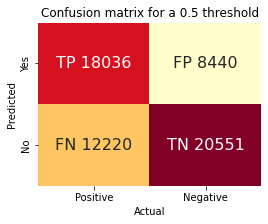

In [28]:
import seaborn as sn
confusion_matrix_05 = compute_confusion_matrix(y_test, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [29]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.651
For the positive case, the precision is 0.681, the recall is 0.596 and the F1 score is 0.636
For the negative case, the precision is 0.627, the recall is 0.709 and the F1 score is 0.665


In [57]:
threshold = np.linspace(0, 1, 100)
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(y_test, prediction_proba, t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'F1 score N')

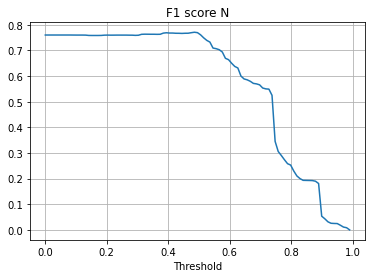

In [59]:
threshold_score['F1 score P'].plot(grid=True).set_title('F1 score N')

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [ ]:
lda_model_2020_100 = LdaMulticore.load('/content/drive/MyDrive/ADA/model_2020__100_topics')
lda_model_2020_20 = LdaMulticore.load('/content/drive/MyDrive/ADA/model_2020__20_topics')

In [ ]:
lda_model_2020_100.show_topics(num_words=5, num_topics=100)

In [ ]:
data2019